In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# switch to the project directory
%cd ../..
# working directory should be ../pdi

/home/mytkom/Documents/alice/pdi


In [3]:
import sys
import os
module_path = os.path.abspath('src')

if module_path not in sys.path:
    sys.path.append(module_path)

#### How to use this notebook?
1. Train models with desired configs and use `scripts` subdirectory scripts to achieve that.
2. Fill `MODELS` dictionary with paths to the results dir of the run and name it appropriately as in dictionary element key.
3. Run desired plot/table generation cells. 

In [4]:
from pdi.constants import PART_NAME_TO_TARGET_CODE

MODELS = {
    "alpha=0": "results/attention_dann_hyperparameter_tuning/best_run_alpha_0",
    "alpha=0.15": "results/attention_dann_hyperparameter_tuning/sweep_118f437672375fa45c5e417106c304a1/kaon/run_25",
}
target_code = PART_NAME_TO_TARGET_CODE["kaon"]

save_dir = "reports"
os.makedirs(save_dir, exist_ok=True)

In [5]:
import json
from pdi.config import Config
from pdi.engines import build_engine
from pdi.results_and_metrics import TestResults
from pdi.data.data_preparation import DataPreparation
from pdi.data.types import Split
from pdi.models import AttentionModelDANN
from numpy.typing import NDArray
import gzip
import pickle

data_prep: DataPreparation = None
checksums = set()
exp_predictions: dict[str, NDArray] = {}
for k, v in MODELS.items():
    with open(f"{v}/config.json", 'r') as f:
        config_data = json.load(f)
    config = Config.from_dict(config_data)
    if config.model.architecture != "attention_dann":
        raise RuntimeError("This notebook is suitable only for DANN!")
    config.training.device = "cpu"
    config.validation.batch_size = 512
    config.validation.num_workers = 2
    engine = build_engine(config, target_code, base_dir=v)
    current_data_prep = engine.get_data_prep()[1]
    if data_prep is None:
        data_prep = current_data_prep
    checksums.add(current_data_prep._inputs_checksum)
    test_results = engine.test(v)
    with gzip.open(f"{v}/experimental_class_predictions.pkl", "r") as file:
        exp_predictions[k] = pickle.load(file) >= test_results.test_metrics.threshold

if len(checksums) > 1:
    raise RuntimeError("You shouldn't compare models trained on different datasets.")

[DataPreparation] Calculating input_paths + configuration checksum:
[DataPreparation] 	resulting checksum: 0858460c6963f0b5c7dce050440ffd05
[DataPreparation] Successfuly loaded preprocessed data! No need for from scratch preparation.
[DataPreparation] Calculating input_paths + configuration checksum:
[DataPreparation] 	resulting checksum: cb3638b8f27a952941ad38bdb37f4570
[DataPreparation] Successfuly loaded preprocessed data! No need for from scratch preparation.
Model attention_dann has been initialized:
	Number of trainable parameters: 463426


Training DANN: 100%|██████████| 1154/1154 [12:48<00:00,  1.50it/s]


Domain label test results:
{'f1': 0.6864291770462283, 'precision': 0.7101526941446122, 'recall': 0.664239447948859, 'accuracy': 0.6964850737167326, 'loss': 1.2495151604275563, 'threshold': 0.5, 'target_code': 321}
Test results:
{'f1': 0.787693959207573, 'precision': 0.8364682107881237, 'recall': 0.7442943427543917, 'accuracy': 0.985256120268853, 'loss': 1.2495151604275563, 'threshold': 0.44996145, 'target_code': 321}
[DataPreparation] Calculating input_paths + configuration checksum:
[DataPreparation] 	resulting checksum: 0858460c6963f0b5c7dce050440ffd05
[DataPreparation] Successfuly loaded preprocessed data! No need for from scratch preparation.
[DataPreparation] Calculating input_paths + configuration checksum:
[DataPreparation] 	resulting checksum: cb3638b8f27a952941ad38bdb37f4570
[DataPreparation] Successfuly loaded preprocessed data! No need for from scratch preparation.
Model attention_dann has been initialized:
	Number of trainable parameters: 463426


Training DANN: 100%|██████████| 1154/1154 [12:41<00:00,  1.51it/s]


Domain label test results:
{'f1': 0.6278154528570377, 'precision': 0.5790975808643654, 'recall': 0.6854832564243681, 'accuracy': 0.5935204821399533, 'loss': 1.4046957649845804, 'threshold': 0.5, 'target_code': 321}
Test results:
{'f1': 0.7569056732574299, 'precision': 0.8031353476821192, 'recall': 0.715708423624879, 'accuracy': 0.9831060417376158, 'loss': 1.4046957649845804, 'threshold': 0.3704135, 'target_code': 321}


In [13]:
predictions, threshold = data_prep.get_normalized_n_sigma(target_code, threshold_unscaled=3.0)
exp_predictions["nSigma"] = predictions >= threshold

#### Extract Unwrapped and Unstandardized Test Split Data as a DataFrame
The test split data is explicitly obtained from the `CombinedDataLoader` to ensure consistency. Only the `CombinedDataLoader` has the knowledge of how to unwrap itself, and it will raise errors if the operation cannot be performed. While this could also be achieved by adding an additional method in the `DataPreparation` class, doing so would require `DataPreparation` to understand the internal structure of the `CombinedDataLoader`. This approach would also necessitate updates to `DataPreparation` whenever changes are made to the `CombinedDataLoader`. Therefore, the current approach is preferred for maintaining separation of concerns and avoiding unnecessary dependencies. It is also thousands times faster than iterating over and over dataloader and concatenating batches.

In [14]:
test_dl = data_prep.create_dataloaders(
    {
        Split.TEST: 1 # not used
    },
    {
        Split.TEST: 1 # not used
    },
    False, False)[Split.TEST]

test_data_unwrapped = test_dl.unwrap()
print(test_data_unwrapped.shape)
test_data_unwrapped.head()

(723863, 28)


,GroupID,fTPCSignal,fTRDPattern,fTOFSignal,fBeta,fP,fPx,fPy,fPz,fSign,...,fTPCNSigmaMu,fTPCNSigmaPi,fTPCNSigmaKa,fTPCNSigmaPr,fTOFNSigmaEl,fTOFNSigmaMu,fTOFNSigmaPi,fTOFNSigmaKa,fTOFNSigmaPr,fPt
0,36863,47.406250,NaN,NaN,NaN,0.546856,-0.216713,-0.501439,0.025431,-1.0,...,-0.685648,-0.467796,-5.623379,-10.518414,-999.0,-999.0,-999.0,-999.0,-999.0,0.546265
1,36863,56.497070,NaN,NaN,NaN,0.334081,0.115721,-0.300313,-0.089613,1.0,...,2.114970,1.497737,-8.797727,-12.418385,-999.0,-999.0,-999.0,-999.0,-999.0,0.321838
2,36863,47.351562,NaN,NaN,NaN,0.268437,0.072209,-0.193736,-0.171204,-1.0,...,-0.880014,-1.882274,-10.981042,-13.227061,-999.0,-999.0,-999.0,-999.0,-999.0,0.206755
3,36863,51.836914,NaN,NaN,NaN,0.302092,0.172456,0.203855,0.141286,1.0,...,0.607694,-0.230517,-10.047462,-12.893145,-999.0,-999.0,-999.0,-999.0,-999.0,0.267016
4,36863,60.394531,NaN,NaN,NaN,0.313564,-0.292980,0.110696,0.015223,1.0,...,3.154410,2.313373,-8.975717,-12.516952,-999.0,-999.0,-999.0,-999.0,-999.0,0.313195


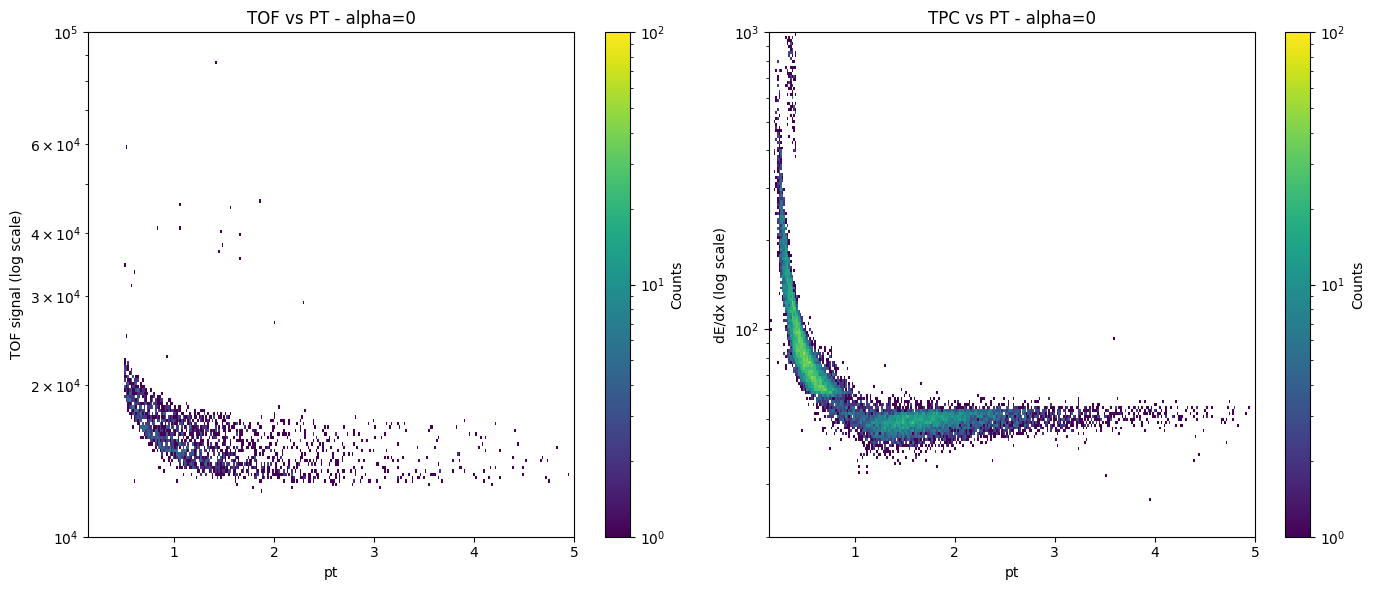

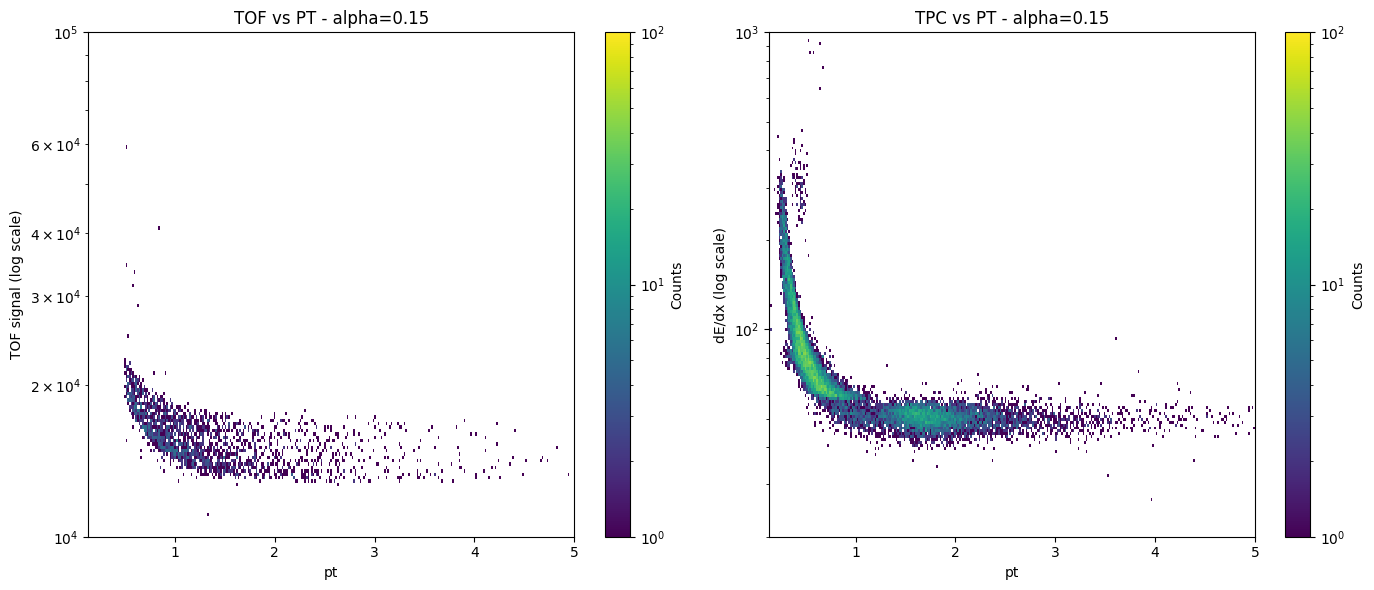

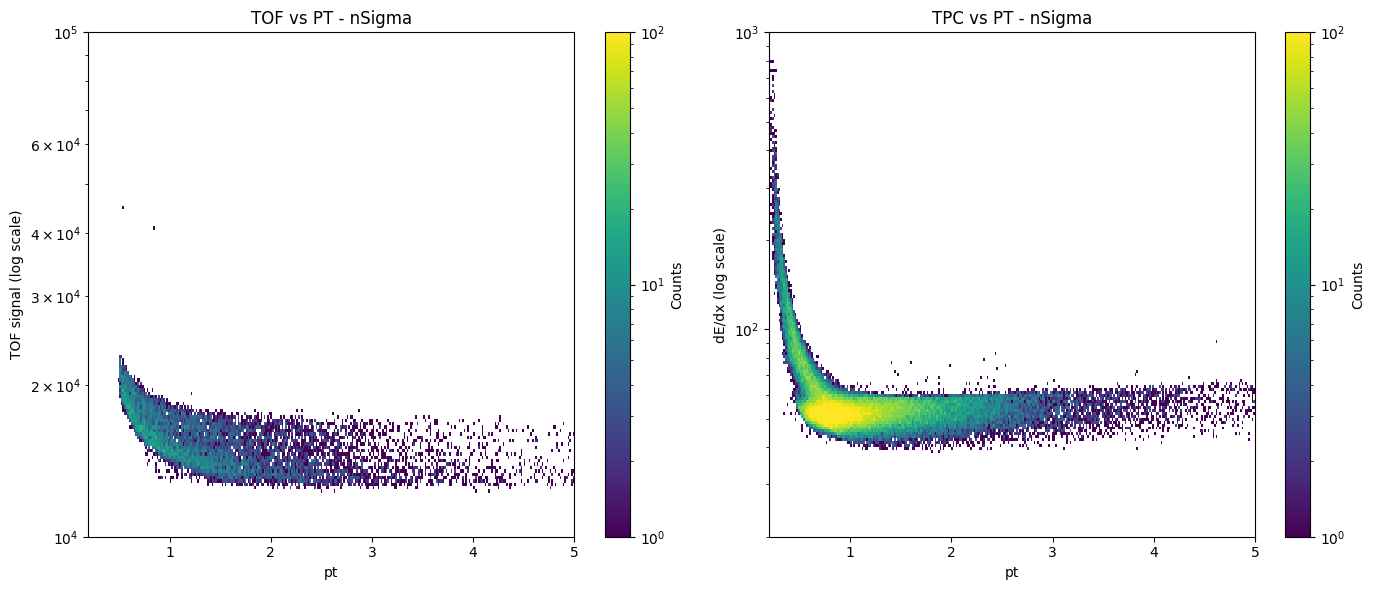

In [15]:
pt = test_data_unwrapped["fPt"]
tof = test_data_unwrapped["fTOFSignal"]
tpc = test_data_unwrapped["fTPCSignal"]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

for model_name, predictions in exp_predictions.items():
    binary_predictions = predictions

    filtered_indices = np.where(predictions)[0]
    filtered_pt = pt[filtered_indices]
    filtered_tof = tof[filtered_indices]
    filtered_tpc = tpc[filtered_indices]

    valid_tof_mask = np.isfinite(filtered_tof) & np.isfinite(filtered_pt) & (filtered_pt > 0) & (filtered_tof > 0)
    valid_tpc_mask = np.isfinite(filtered_tpc) & np.isfinite(filtered_pt) & (filtered_pt > 0) & (filtered_tpc > 0)

    filtered_pt_tof = filtered_pt[valid_tof_mask]
    filtered_tof = filtered_tof[valid_tof_mask]

    filtered_pt_tpc = filtered_pt[valid_tpc_mask]
    filtered_tpc = filtered_tpc[valid_tpc_mask]

    pt_bins = np.linspace(filtered_pt.min(), 5., 300)
    tof_bins = np.logspace(np.log10(10e3), np.log10(10e5), 300)
    tpc_bins = np.logspace(np.log10(10e0), np.log10(10e3), 300)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    hist_tof = plt.hist2d(filtered_pt_tof, filtered_tof, bins=[pt_bins, tof_bins], norm=LogNorm(vmin=1, vmax=10e1))
    plt.colorbar(label='Counts')
    plt.yscale('log')
    plt.ylim((10e3, 10e4))
    plt.xlabel('pt')
    plt.ylabel('TOF signal (log scale)')
    plt.title(f'TOF vs PT - {model_name}')

    plt.subplot(1, 2, 2)
    hist_tpc = plt.hist2d(filtered_pt_tpc, filtered_tpc, bins=[pt_bins, tpc_bins], norm=LogNorm(vmin=1, vmax=10e1))
    plt.colorbar(label='Counts')
    plt.yscale('log')
    plt.xlabel('pt')
    plt.ylim((2e1, 10e2))
    plt.ylabel('dE/dx (log scale)')
    plt.title(f'TPC vs PT - {model_name}')

    plt.tight_layout()
    plt.show()